In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
from time import time
warnings.filterwarnings('ignore')

init = time()

In [2]:
california_ozone = pd.read_csv("../../data/cal_o3.csv.gz", index_col = None)

In [3]:
cadf = california_ozone
cadf = cadf[cadf['Time Local'] <= '18:00']
cadf = cadf[cadf['Time Local'] >= '10:00']

In [4]:
county_codes = cadf['County Code'].values
site_code = cadf['Site Num'].values
site_id = [str(county_codes[i]) + str(site_code[i]) for i in range(len(county_codes))]

In [5]:
cadf['ID'] = site_id

In [6]:
mask = cadf.groupby(['ID', 'Date Local'])['Sample Measurement'].count() >= 8

In [7]:
cadf = cadf.groupby(['ID', 'Date Local']).mean()[mask]

In [8]:
cadf.reset_index(inplace=True)

In [9]:
cadf = cadf[['ID', 'Date Local', 'Latitude', 'Longitude', 'Sample Measurement']]

In [10]:
m1 = cadf['Date Local'] >= '1990-05-01'
m2 = cadf['Date Local'] <= '1990-09-30'
mf = m1 & m2
cadf = cadf[mf]

In [11]:
m4 = cadf.groupby('ID').count()>=115

In [12]:
cadf = cadf.groupby('ID').mean()[m4]

In [13]:
cadf.dropna(inplace = True)

In [14]:
ca_df = cadf.copy()

## Let us load California Centroids for Interpolation

### Before that, let us visualize California and nearby regions!

In [15]:
import geopandas as gpd

Venture - 111, Orange - 59, Riverside - 65, San Bernardino - 71, LA - 36

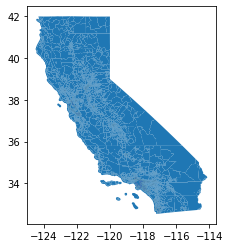

In [16]:
gdf = gpd.read_file("../../data/block_groups/california/tl_2016_06_bg.shp")
# gdf = gdf[gdf['COUNTYFP'].isin(['037', '059', '111'])]
gdf['INTPTLAT'] = np.float64(gdf['INTPTLAT'].values)
gdf['INTPTLON'] = np.float64(gdf['INTPTLON'].values)
# gdf = gdf[gdf['INTPTLAT']>=33.6]
# gdf = gdf[gdf['INTPTLAT']<=35.5]
# gdf = gdf[gdf['INTPTLON']>=-119.4]
gdf.plot();

## The 10 counties are those mentioned in Wikipedia for South California

In [17]:
scgdf = gdf[gdf['COUNTYFP'].isin(['025','026','037','059','065','071','073','079','083','111'])]

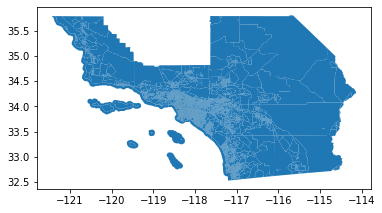

In [18]:
scgdf.plot();

In [19]:
shapes = scgdf['geometry'].unique()
centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
centroids = np.array(centroids)

In [20]:
centroids.shape

(13167, 2)

## We are only interested in california for Kriging Interpolation of O3

## Let us interpolate over California!

In [21]:
cadf1 = cadf.copy()

In [22]:
cadf1 = cadf1[cadf1['Latitude']<=35.7839132]

In [23]:
X = cadf1[['Longitude', 'Latitude']].values
y = cadf1[['Sample Measurement']].values * 1000

### Kriging Interpolation

In [24]:
from polire import Kriging
## PyKrige takes Longitude Values in the Range 0 to 360 => Add 360 to our values!
X_krig = X.copy()
X_test_krig = centroids.copy()
# X_krig[:, 0] = X_krig[:, 0] + 360
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X_krig, y.ravel())

X_test_krig[:, 0] = X_test_krig[:, 0] + 360
krig_predictions = krig.predict(X_test_krig)

### Spatial Average

In [25]:
from polire import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y.ravel())
spatial_predictions = spatial.predict(centroids)

### IDW

For IDW, the authors choose a 250 km radius. Let us likewise choose our training points and use the IDW Class repeatedly.

ToolkitName supports geographic coordinates and hence we have that distance too!

In [26]:
from polire import IDW
from polire.utils.distance import haversine, euclidean
idw = IDW(coordinate_type='Geographic', exponent=1)
idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(np.array(data_point).reshape(1,2), X).ravel()
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    idw.fit(X_train, y_train.ravel())
    idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [27]:
from polire import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor(n_neighbors=1))
knn.fit(X, y.ravel())
knn_predictions = knn.predict(centroids)

In [28]:
krig_predictions = np.array(krig_predictions).reshape(-1,)

In [29]:
spatial_predictions = np.array(spatial_predictions).reshape(-1,)

In [30]:
idw_predictions = np.array(idw_predictions).reshape(-1,)

In [31]:
temp = []
for i in spatial_predictions:
    try:
        j = i[0]
        temp.append(j)
    except:
        temp.append(i)

In [32]:
spatial_predictions = spatial_predictions[~np.isnan(temp)]

In [33]:
krig_predictions.mean(), idw_predictions.mean(), spatial_predictions.mean(), knn_predictions.mean()

(57.11764108041225, 58.28237829580222, 55.23232688604564, 54.68536373627176)

## SOCAL PREDICTION ABOVE

In [34]:
def predict(gdf, df, lat):
    df = df[df['Latitude']<=lat]
    gdf = gdf[gdf['INTPTLAT']<=lat]
    shapes = gdf['geometry'].unique()
    centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
    centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
    centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
    centroids = np.array(centroids)
    X = df[['Longitude', 'Latitude']].values
    y = df[['Sample Measurement']].values * 1000
    
    
    from polire import IDW
    from polire.utils.distance import haversine, euclidean
    idw = IDW(coordinate_type='Geographic', exponent=1)
    idw_predictions = np.zeros(centroids.shape[0])
    for ix, data_point in enumerate(centroids):
        distances = haversine(np.array(data_point).reshape(1,2), X).ravel()
        mask = distances <= 250
        X_train = X[mask]
        y_train = y[mask]
        idw.fit(X_train, y_train.ravel())
        idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))
    
    from polire import CustomInterpolator
    from sklearn.neighbors import KNeighborsRegressor
    knn = CustomInterpolator(KNeighborsRegressor(n_neighbors=1))
    knn.fit(X, y.ravel())
    knn_predictions = knn.predict(centroids)
    
    from polire import SpatialAverage
    spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
    spatial.fit(X, y.ravel())
    spatial_predictions = spatial.predict(centroids)
    temp = []
    for i in spatial_predictions:
        try:
            j = i[0]
            temp.append(j)
        except:
            temp.append(i)
    spatial_predictions = spatial_predictions[~np.isnan(temp)]   
    
    
    from polire import Kriging
    X_krig = X.copy()
    X_test_krig = centroids.copy()
    # X_krig[:, 0] = X_krig[:, 0] + 360
    krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
    krig.fit(X_krig, y.ravel())

    X_test_krig[:, 0] = X_test_krig[:, 0] + 360
    krig_predictions = krig.predict(X_test_krig)
    
    print(krig_predictions.mean(), idw_predictions.mean(), spatial_predictions.mean(), knn_predictions.mean())
    
    
    
    

In [35]:
for i in np.linspace(35,45,21):
    print(i)
    predict(gdf, cadf, i)

35.0
56.68852808055028 58.33406423830523 55.45425573771736 54.92813709530413
35.5
55.23883617604768 58.37142906662613 55.55427697676483 55.06366032668049
36.0
57.423654518535955 58.335483781624646 55.539639035327525 55.09763531055316
36.5
56.81529444264114 58.25552163857745 55.63032187338544 55.24816146136425
37.0
57.619558116102894 57.714595286435035 55.404060246341146 54.996253853696885
37.5
55.824775832985914 55.768775458087674 53.64077777699844 53.3810975352638
38.0
51.51482794958998 51.948943641960945 49.33137175492026 49.224964397306486
38.5
50.82761276963408 51.22793779399006 48.76339843314996 48.68061312923772
39.0
51.009703352767175 51.34803587748715 48.769830380621684 48.68737389760437
39.5
50.98656877738992 51.27532229812349 48.76708606366952 48.650088615646546
40.0
50.46149387755981 51.21712269113345 48.75488820106701 48.62967743572559
40.5
50.445603639893115 51.19294674189088 48.75488820106701 48.62286832007122
41.0
49.75808017874365 51.183800359098825 48.776347877922646 4

In [36]:
print('Finished in', (time()-init)/60, 'minutes')

Finished in 2.488683835665385 minutes
